## Requirements
- Divide the crops into teams based on their joursey-color

## Plan
1. Create Image Embeddings using SigLip Model
2. Dimensionality Reduction using uMap
3. K-means for divinding the emmbeddings into 2 cluster (1 for each team)


In [1]:
!pip install supervision umap-learn ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.1 MB/s eta 0:00:00


In [28]:
import supervision as sv
from ultralytics import YOLO

import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import gdown

In [3]:
# YOLO MODEL
!gdown https://drive.google.com/uc?id=1WosrbYsPjJ6DLq1Izd-dOWOj4D8njwL4

Downloading...
From (original): https://drive.google.com/uc?id=1WosrbYsPjJ6DLq1Izd-dOWOj4D8njwL4
From (redirected): https://drive.google.com/uc?id=1WosrbYsPjJ6DLq1Izd-dOWOj4D8njwL4&confirm=t&uuid=97936508-858b-4a72-b006-2becb6c9b92f
To: /content/last.pt
100% 40.5M/40.5M [00:01<00:00, 28.5MB/s]


In [ ]:
# Video FIles
!gdown -O "video1.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
!gdown -O "video1.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
!gdown -O "video1.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
!gdown -O "video2.mp4" "https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf"
!gdown -O "video3.mp4" "https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-"
!gdown -O "video4.mp4" "https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU"
!gdown -O "video5.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

In [7]:
yolo=YOLO("./weights/last.pt")

In [8]:
def get_crops(video_path,stride=30,image_name_pattern="image_{:05d}.png"):
  video_info=sv.VideoInfo.from_video_path(video_path)
  frame_generator=sv.get_video_frames_generator(video_path,stride=stride)
  crops=[]
  for i,frame in tqdm(enumerate(frame_generator),desc=f"generating crops for {video_path}",total=video_info.total_frames//stride):
    results=yolo.predict(frame,verbose=False)[0]
    detections=sv.Detections.from_ultralytics(results)
    detections=detections.with_nms(threshold=0.5,class_agnostic=True)

    players=detections[detections.class_id==2]
    temp_frame=frame

    if len(players)>0:
      crops+=[
          sv.crop_image(temp_frame,player[0]) for player in players
      ]
  return crops


In [11]:
from functools import reduce

video_files=[rf"./video{i}.mp4" for i in range(1,6)]
video_files.append(rf"./video.mp4")

# video_files=["/content/573e61_0.mp4"]

player_crops=list(map(get_crops,video_files))
player_crops=list(reduce(lambda x,y:x+y,player_crops))


generating crops for ./video.mp4: 100%|██████████| 25/25 [00:20<00:00,  1.25it/s]


In [12]:
len(player_crops)

2896

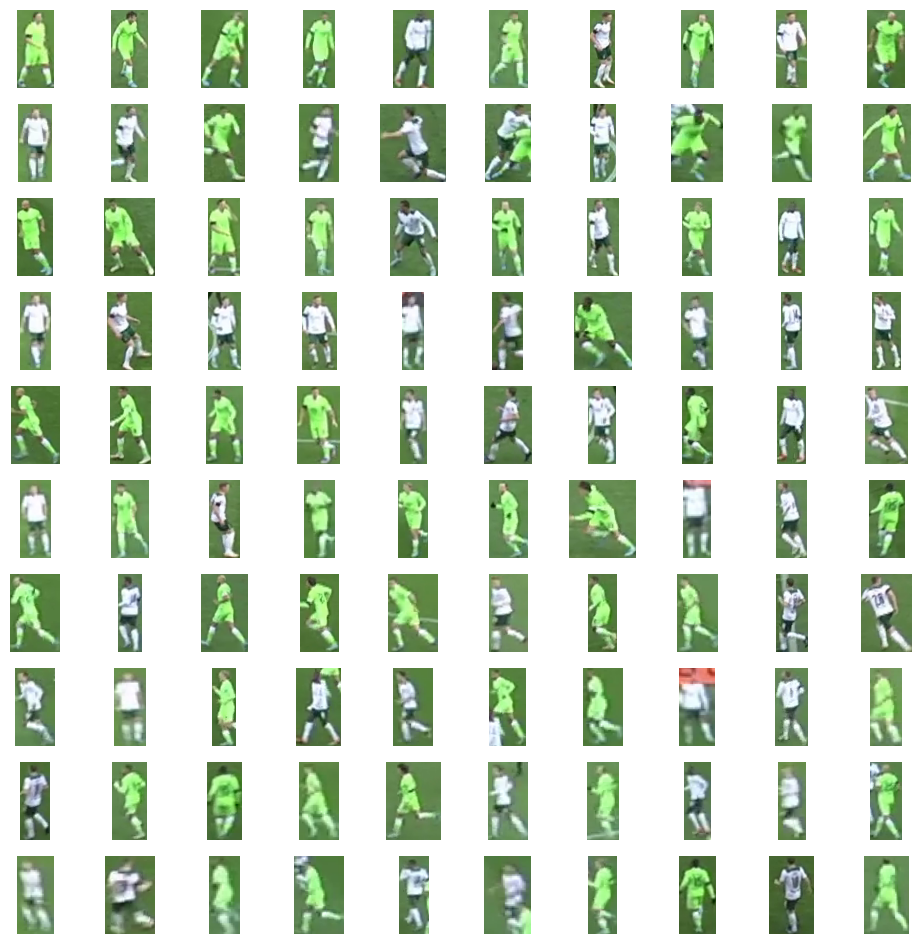

In [32]:
sv.plot_images_grid(player_crops[:100],(10,10))

## SigLip

In [15]:
from transformers import AutoProcessor,AutoModel
from torchsummary import summary

embeddings_model_config=r"google/siglip-base-patch16-224"

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_PROCESSOR=AutoProcessor.from_pretrained(embeddings_model_config,cache_dir=rf"./weights")
EMBEDDINGS_MODEL=AutoModel.from_pretrained(embeddings_model_config,cache_dir=rf"./weights").to(DEVICE)

In [16]:
DEVICE

'cpu'

In [35]:
# Siglip requires img in PIL format
pillow_player_crops=list(map(sv.cv2_to_pillow,player_crops))

from toolz.itertoolz import partition_all
batch_size=32
batches=list(partition_all(batch_size,pillow_player_crops))

data=[]
with torch.no_grad():
  for batch in tqdm(batches, desc='Siglip image embedding extraction'):
    inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)

    # Extract image features
    image_embeddings = EMBEDDINGS_MODEL.get_image_features(**inputs)
    data.append(image_embeddings.cpu().numpy())

data=np.concatenate(data)

Siglip image embedding extraction: 100%|██████████| 91/91 [22:17<00:00, 14.69s/it]


In [36]:
data.shape

(2896, 768)

## Using umap and kmean :
- umap for dimensionality reduction to get only features that explain most variance
- kmeans to divide teams into 2 cluster based on embeddings

In [38]:
import umap.umap_ as umap
from sklearn.cluster import KMeans

REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2,init='k-means++')

In [39]:
reduced_embedding=REDUCER.fit_transform(data)
output=CLUSTERING_MODEL.fit_predict(reduced_embedding)

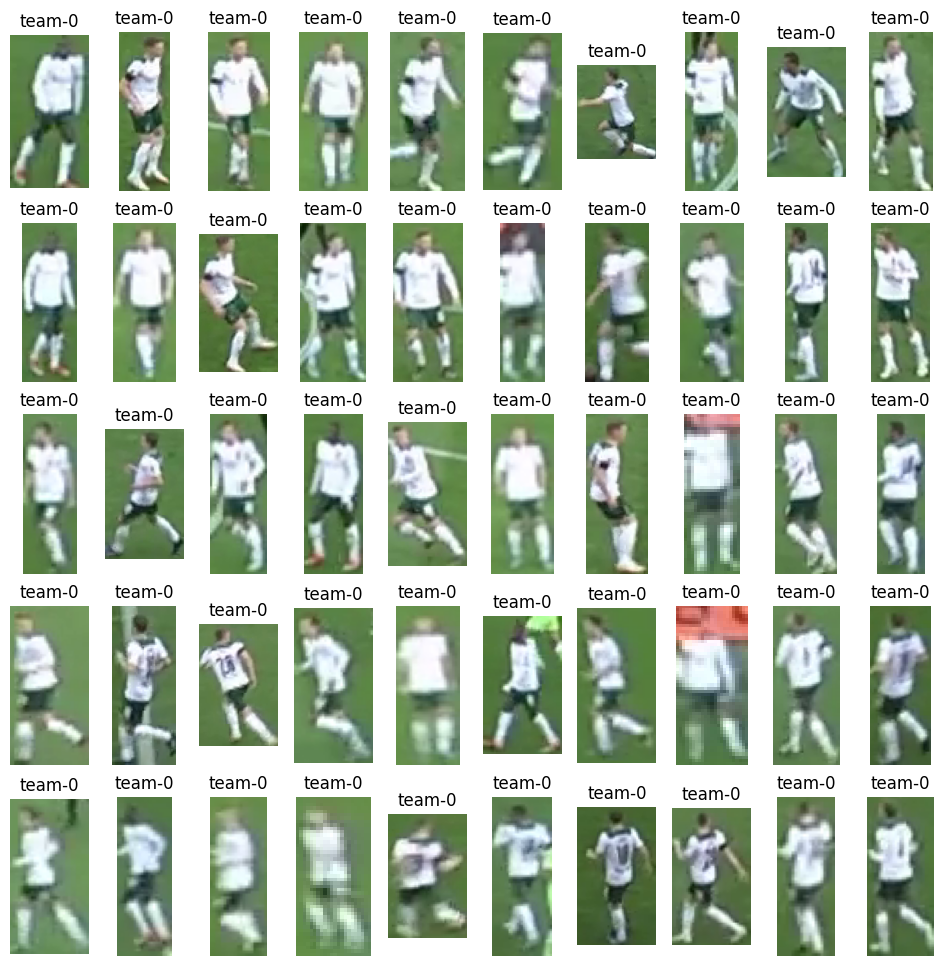

In [40]:
# Team-0
team_0_indices = [i for i, o in enumerate(output) if o == 0]
team_0_crops = [player_crops[i] for i in team_0_indices]

sv.plot_images_grid(team_0_crops[:50],grid_size=(5,10),titles=["team-0"]*50)

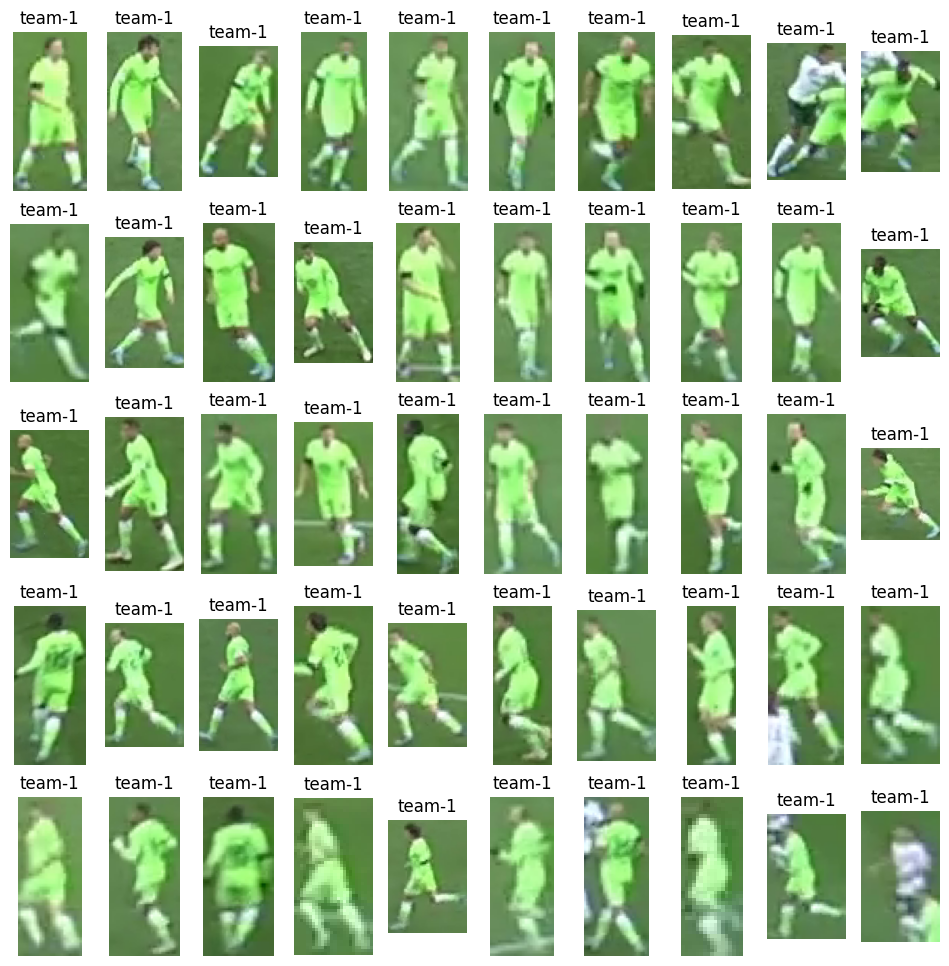

In [41]:
team_1_indices = [i for i, o in enumerate(output) if o == 1]
team_1_crops = [player_crops[i] for i in team_1_indices]

# Display images in a grid
sv.plot_images_grid(team_1_crops[:50],grid_size=(5,10),titles=["team-1"]*50)  # Adjust grid size as needed
plt.show()

In [42]:
import pickle

with open("./weights/CLUSTERING_MODEL.pkl","wb") as f:
  pickle.dump(CLUSTERING_MODEL,f)

with open("./weights/REDUCER.pkl","wb") as f:
  pickle.dump(REDUCER,f)

In [31]:
from google.colab import files

files.download('CLUSTERING_MODEL.pkl')
files.download('REDUCER.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>